In [16]:
!pip install wordcloud

In [5]:
!pip install ipywidgets

In [2]:
!pip install kagglehub

In [90]:
!pip install bokeh

  Using cached xyzservices-2025.1.0-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.5 MB/s eta 0:00:00a 0:00:01
Using cached xyzservices-2025.1.0-py3-none-any.whl (88 kB)


In [91]:
import pandas as pd # для обработки и анализа данных
import numpy as np # для математических вычислений
from tqdm.auto import tqdm # для отслеживания прогресса длительных операций
import matplotlib.pyplot as plt # для визуализации
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import re
from string import punctuation
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import Word2Vec
import gensim.downloader as api
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from sklearn.manifold import TSNE



In [92]:
nltk.download('stopwords')
nltk.download('wordnet')

output_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading BokehJS ...

In [10]:
data_train = pd.read_csv('data/train.csv', sep=',')
data_test = pd.read_csv('data/test.csv', sep=',')


In [13]:
data_train['label'].unique()

array([2, 3, 1, 0])

In [14]:
labels_train = data_train['label']
labels_test = data_test['label']

len(labels_train)
# Output:
# 120000


120000

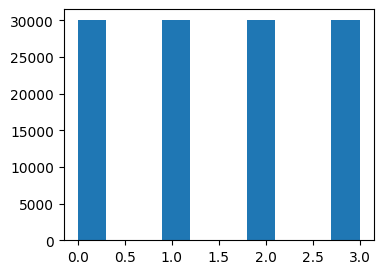

In [15]:
plt.figure(figsize=(4, 3))
plt.hist(labels_train);


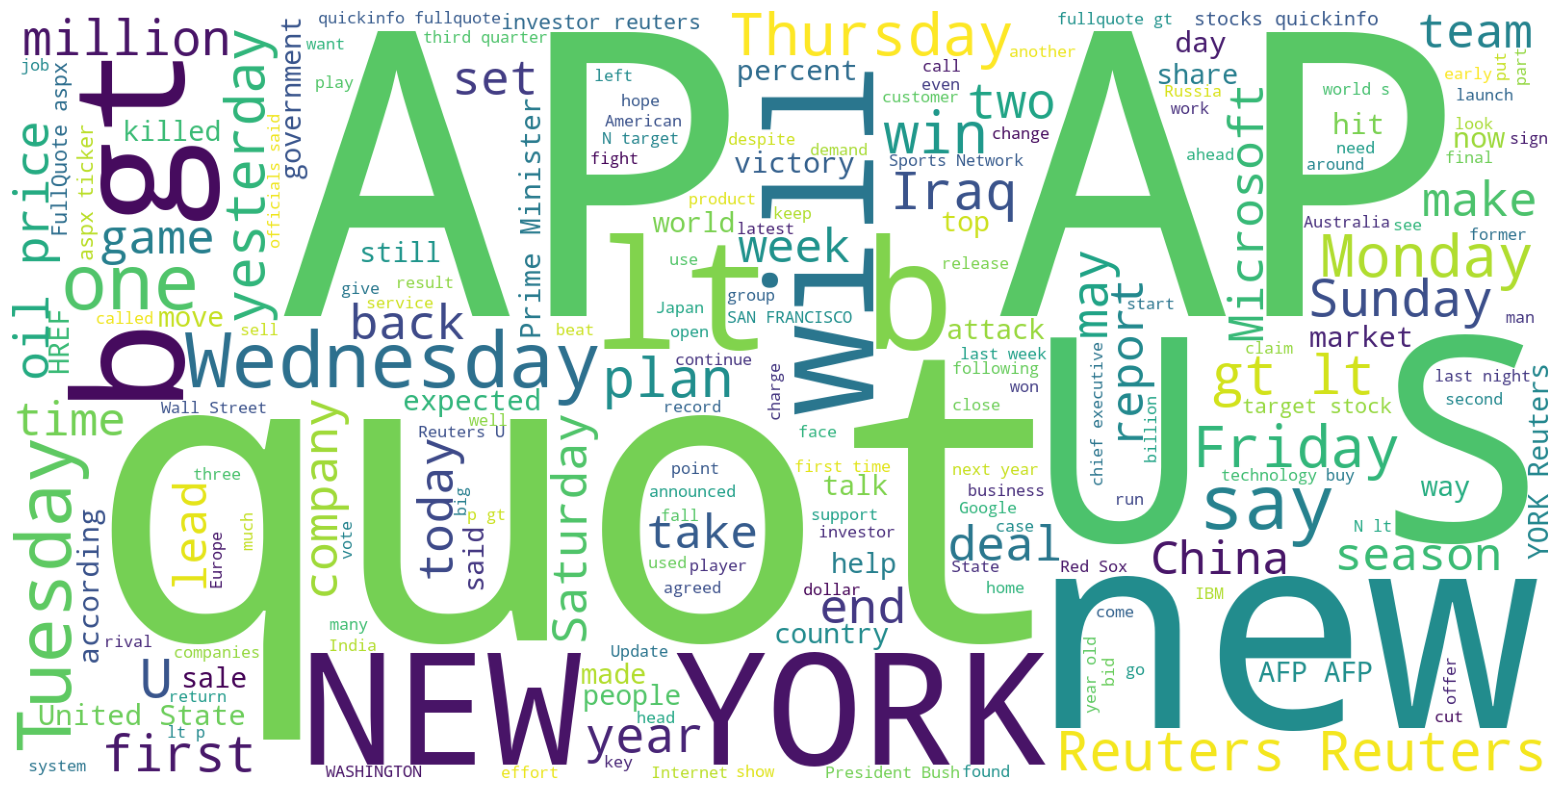

In [19]:
def create_cloud_graph(corpus):
    """
    Функция для создания облака частотных слов текста
    """
    wordcloud = WordCloud(
    width=1600, height=800, max_words=200, background_color='white', collocations=True
    ).generate(' '.join(corpus))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

create_cloud_graph(data_train['text'])


In [21]:
bow_vectorizer = CountVectorizer(min_df=1)
bow_vectorizer.fit(data_train['text']);


In [22]:
bow_vector = bow_vectorizer.transform(data_train['text'][:1])

bow_vector.shape
# Output:
# (1, 65006)


(1, 65006)

In [23]:
bow_vectorizer = CountVectorizer(min_df=4, max_df=0.95)
bow_vectorizer.fit(data_train['text']);

In [24]:
bow_vector = bow_vectorizer.transform(data_train['text'][:1])
bow_vector.shape
# Output:
# (1, 29350)


(1, 29350)

## LogisticRegression - Baseline

In [26]:
def train_eval_model(train_X, test_X, train_y, test_y):
    model = LogisticRegression(max_iter=500)
    model.fit(train_X, train_y)

    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)

    train_acc = accuracy_score(train_y, train_pred)
    test_acc = accuracy_score(test_y, test_pred)

    print('Train accuracy:', round(train_acc, 3))
    print('Test accuracy: ', round(test_acc, 3))


In [27]:
bow_train = bow_vectorizer.transform(data_train['text'])
bow_test = bow_vectorizer.transform(data_test['text'])


In [28]:
train_eval_model(bow_train, bow_test, labels_train, labels_test)

# Output:
# Train accuracy: 0.978
# Test accuracy:  0.909


Train accuracy: 0.978
Test accuracy:  0.909


/root/projects/nlp/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## TF-IDF

In [31]:
tfidf_vectorizer = TfidfVectorizer(min_df=4, max_df=0.95)
tfidf_vectorizer.fit(data_train['text']);

tfidf_train = tfidf_vectorizer.transform(data_train['text'])
tfidf_test = tfidf_vectorizer.transform(data_test['text'])

train_eval_model(tfidf_train, tfidf_test, labels_train, labels_test)

# Output:
# Train accuracy: 0.941
# Test accuracy:  0.917


Train accuracy: 0.941
Test accuracy:  0.917


## Визуализация эмбеддингов

In [33]:
tsne_vectors = TSNE(
    n_components=2, learning_rate='auto', init='random', perplexity=30
).fit_transform(tfidf_train[-2000:])

tsne_vectors.shape
# Output:
# (2000, 2)

colors = labels_train[-2000:]
classes = ['World', 'Sports', 'Business', 'Sci/Tech']


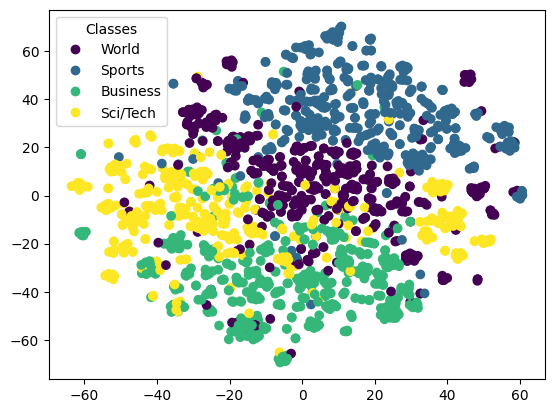

In [37]:
scatter = plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=colors)
plt.legend(scatter.legend_elements()[0], classes, title="Classes")


## Поиск похожих текстов

In [ ]:
texts = data_train['text'][:1000]
text_embeddings = tfidf_train[:1000].toarray()

In [40]:
def cosine(embedding, other_embeddings):
    """
    Функция для оценки косинусной близости
    """
    normed_embeddings = other_embeddings.T / np.linalg.norm(other_embeddings, axis=1)
    return embedding @ normed_embeddings

def find_nearest(query, k=10):
    """
    Функция для поиска похожих текстов
    """
    embedding = tfidf_vectorizer.transform([query])    
    similarities = cosine(embedding, text_embeddings)[0]
    nearest_idxs = np.argsort(similarities)[-k:][::-1]

    return list(texts[nearest_idxs])


In [41]:
nearest = find_nearest(query="Bill Gates is the head of Microsoft", k=5)

for text in nearest:
    print(text)
    print()


Microsoft Says Battle in Japan Hurting Image By YURI KAGEYAMA     TOKYO (AP) -- The head of Microsoft Corp. (MSFT)'s Japan unit acknowledged Tuesday that the U.S...

Microsoft Corp. 2.0: a kinder corporate culture Even a genius can mess up. Bill Gates was a brilliant technologist when he cofounded Microsoft , but as he guided it to greatness in both size and historical consequence, he blundered. He terrorized underlings with his temper and parceled out praise like Scrooge gave to charity. Only the lash inspired the necessary aggressiveness to beat the competition, he thought.

Entertainment World Wary of Microsoft (AP) AP - CinemaNow Inc., the Internet-based movie service, is a rarity in Hollywood  #151; a company that eagerly embraces Microsoft Corp. technology and relies on it exclusively to transmit, protect and display the movies it rents to customers. Then again, Microsoft is a major investor in the company, which is also owned by independent studio Lions Gate.

Taking the Microso

## Токенизация

In [45]:
def tokenize1(text):
    """
    Токенизация текста с помощью циклов в python
    """
    for p in punctuation:
        text = text.replace(p, ' ')

    text = text.strip().split()

    return text

def tokenize(text):
    """
    Токенизация текста с помощью регулярных выражений
    """
    reg = re.compile(r'\w+')

    return reg.findall(text)



In [46]:
data_train['text'][50]
# Output:
# 'Making Your Insurer Pay If Hurricane Charley blows your house down, how can you make your insurance company pay?'

print(tokenize(data_train['text'][50]))
# Output:
# ['Making', 'Your', 'Insurer', 'Pay', 'If', 'Hurricane', 'Charley', 'blows', 'your', 'house', 'down', 'how', 'can', 'you', 'make', 'your', 'insurance', 'company', 'pay']


['Making', 'Your', 'Insurer', 'Pay', 'If', 'Hurricane', 'Charley', 'blows', 'your', 'house', 'down', 'how', 'can', 'you', 'make', 'your', 'insurance', 'company', 'pay']


In [48]:
print(wordpunct_tokenize(data_train['text'][50]))

['Making', 'Your', 'Insurer', 'Pay', 'If', 'Hurricane', 'Charley', 'blows', 'your', 'house', 'down', ',', 'how', 'can', 'you', 'make', 'your', 'insurance', 'company', 'pay', '?']


In [49]:
data_tok_train = [tokenize(t.lower()) for t in data_train['text']]
data_tok_test = [tokenize(t.lower()) for t in data_test['text']]

print(data_tok_train[:2])
# Output:
# [['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], ['carlyle', 'looks', 'toward', 'commercial', 'aerospace', 'reuters', 'reuters', 'private', 'investment', 'firm', 'carlyle', 'group', 'which', 'has', 'a', 'reputation', 'for', 'making', 'well', 'timed', 'and', 'occasionally', 'controversial', 'plays', 'in', 'the', 'defense', 'industry', 'has', 'quietly', 'placed', 'its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market']]


[['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], ['carlyle', 'looks', 'toward', 'commercial', 'aerospace', 'reuters', 'reuters', 'private', 'investment', 'firm', 'carlyle', 'group', 'which', 'has', 'a', 'reputation', 'for', 'making', 'well', 'timed', 'and', 'occasionally', 'controversial', 'plays', 'in', 'the', 'defense', 'industry', 'has', 'quietly', 'placed', 'its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market']]


## Удаление стоп-слов

In [55]:
stop_words = stopwords.words('english')
# Добавим наиболее встречающиеся слова в наших текстах
stop_words += ['ap', 'us', 'u', '39']
print(stop_words)


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [56]:
def remove_stopwords(tokenized_texts):
    """
    Функция для удаления стоп-слов
    Сохраняем слова, которые не встречаются в списке стоп-слов
    """
    clear_texts = []
    for words in tokenized_texts:
        clear_texts.append([word for word in words if word not in stop_words])

    return clear_texts


In [57]:
data_tok_train = remove_stopwords(data_tok_train)
data_tok_test = remove_stopwords(data_tok_test)

print(data_train['text'][50])
# Output:
# Making Your Insurer Pay If Hurricane Charley blows your house down, how can you make your insurance company pay?

print(data_tok_train[50])
# Output:
# ['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']


Making Your Insurer Pay If Hurricane Charley blows your house down, how can you make your insurance company pay?
['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']


## Стемминг

In [60]:
def stem_text(tokenized_texts):
    """
    Функция для стемминга
    """
    stemmed_data = []
    stemmer = PorterStemmer()
    # Получив набор токенизированных текстов, находим основу для каждого слова
    # -> Соберем новый корпус
    for words in tqdm(tokenized_texts):
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_data.append(stemmed_words)
        
    return stemmed_data


In [61]:
stemmed_train = stem_text(data_tok_train)
stemmed_test = stem_text(data_tok_test)

# токенизированные тексты
print(data_tok_train[50])
# Output:
# ['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']

# токенизированные тексты после стемминга
print(stemmed_train[50])
# Output:
# ['make', 'insur', 'pay', 'hurrican', 'charley', 'blow', 'hous', 'make', 'insur', 'compani', 'pay']


100%|██████████| 7600/7600 [00:03<00:00, 1976.04it/s]

['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']
['make', 'insur', 'pay', 'hurrican', 'charley', 'blow', 'hous', 'make', 'insur', 'compani', 'pay']


#### Обучим TF-IDF на новом корпусе

In [62]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=4)
tfidf_vectorizer.fit(stemmed_train);

tfidf_vectorizer.transform(stemmed_train[:1]).shape
# Output:
# (1, 20096)


/root/projects/nlp/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1, 20095)

In [63]:
tfidf_stemmed_train = tfidf_vectorizer.transform(stemmed_train)
tfidf_stemmed_test = tfidf_vectorizer.transform(stemmed_test)

train_eval_model(tfidf_stemmed_train, tfidf_stemmed_test, labels_train, labels_test)
# Output:
# Train accuracy: 0.935
# Test accuracy:  0.912


Train accuracy: 0.934
Test accuracy:  0.911


## Лемматизация

In [68]:
def lemmatize_text(tokenized_texts):
    """
    Функция для лемматизации текста
    """
    lemmatized_data = []
    lemmatizer = WordNetLemmatizer()
    
    for i, words in enumerate(tqdm(tokenized_texts)):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)

    return lemmatized_data
    
    
lemmatized_train = lemmatize_text(data_tok_train)
lemmatized_test = lemmatize_text(data_tok_test)


100%|██████████| 7600/7600 [00:00<00:00, 8258.04it/s]


In [69]:
# токенизированный текст
print(data_tok_train[50])
# Output:
# ['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']

# токенизированный текст после лемматизации
print(lemmatized_train[50])
# Output:
# ['making', 'insurer', 'pay', 'hurricane', 'charley', 'blow', 'house', 'make', 'insurance', 'company', 'pay']


['making', 'insurer', 'pay', 'hurricane', 'charley', 'blows', 'house', 'make', 'insurance', 'company', 'pay']
['making', 'insurer', 'pay', 'hurricane', 'charley', 'blow', 'house', 'make', 'insurance', 'company', 'pay']


#### Обучим TF-IDF на новом корпусе

In [70]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=4)
tfidf_vectorizer.fit(lemmatized_train);

tfidf_vectorizer.transform(lemmatized_train[:1]).shape
# Output:
# (1, 25833)


/root/projects/nlp/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1, 25844)

In [71]:
tfidf_lemmatized_train = tfidf_vectorizer.transform(lemmatized_train)
tfidf_lemmatized_test = tfidf_vectorizer.transform(lemmatized_test)

train_eval_model(tfidf_lemmatized_train, tfidf_lemmatized_test, labels_train, labels_test)
# Output:
# Train accuracy: 0.938
# Test accuracy:  0.913


Train accuracy: 0.938
Test accuracy:  0.913


## Тематическое моделирование

In [73]:
id2word = Dictionary(lemmatized_train)

In [76]:
print(id2word)

Dictionary<58231 unique tokens: ['back', 'band', 'bear', 'black', 'claw']...>


In [74]:
corpus = [id2word.doc2bow(text) for text in lemmatized_train]


In [77]:
"""
Обучение LDA модели
- corpus - корпус наших текстов
- id2word - словарь из лемматизированных текстов
- num_topics - количество тем, которые мы будем выделять из корпуса
"""
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=8
)


In [78]:
topics = lda_model.show_topics(formatted=False)

# Преобразуем выход метода show_topics() для получения табличного вывода
topics = {f'topic {i}': [pair[0] for pair in topic[1]] for i, topic in enumerate(topics)}

pd.DataFrame(topics)


,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7
0,game,gt,new,year,said,reuters,deal,win
1,new,lt,microsoft,red,iraq,oil,company,1
2,quot,b,software,one,reuters,said,said,game
3,google,reuters,service,state,minister,year,court,world
4,player,fullquote,company,new,official,price,bush,first
5,coach,com,computer,team,leader,sale,president,2
6,season,n,technology,sony,afp,percent,chief,cup
7,night,target,internet,two,government,stock,new,second
8,first,ticker,phone,season,palestinian,new,executive,victory
9,one,http,ibm,test,killed,share,plan,final


## Эмбеддинги слов

In [82]:

model = Word2Vec(
    lemmatized_train, # лемматизированный текст
    vector_size=100,  # размер вектора эмбеддинга
    min_count=4,      # игнорируем слова, которые встречаются слишком редко
    window=5          # размер контекстного окна при обучении
).wv


In [ ]:
model.most_similar('word')

[('blog', 0.6898157596588135),
 ('know', 0.683689296245575),
 ('seems', 0.6777012944221497),
 ('read', 0.6774354577064514),
 ('else', 0.6656008362770081),
 ('wrote', 0.6594935059547424),
 ('experience', 0.6589639186859131),
 ('fact', 0.6571457386016846),
 ('nothing', 0.6531531810760498),
 ('wish', 0.6488698124885559)]

In [86]:
model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [87]:
model.most_similar(positive=["king", "woman"], negative=["man"])


[('queen', 0.7052316069602966),
 ('prince', 0.6666139364242554),
 ('mother', 0.6436765193939209),
 ('royal', 0.6417251229286194),
 ('father', 0.5952690243721008),
 ('african', 0.5883978009223938),
 ('princess', 0.588217556476593),
 ('called', 0.5842776894569397),
 ('meets', 0.584027886390686),
 ('american', 0.5815179944038391)]

## Визуализация эмбеддинга слов

In [88]:
words = model.index_to_key[:1000]
word_vectors = np.array([model.get_vector(word) for word in words])


In [93]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """
    Функция строит интерактивный график
    Наведя курсор на точки, можно посмотреть, какие слова им соответствуют!
    """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs})

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    
    return fig


In [94]:
word_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(word_vectors)
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)


figure(id='p1004', ...)

In [95]:
def get_text_embedding(words):
    """
    Функция принимает на вход набор слов
    Находит эмбеддинг для каждого слова
    Далее усредняет эмбеддинги слов по их количеству

    Функция возвращает эмбеддинг для всего текста с размером 100,
    вместо десятки тысяч, как было при применении BoW, TF-IDF
    """
    embeddings = np.array([model.get_vector(word) for word in words if word in model])
    embedding = np.mean(embeddings, axis=0)
    
    return embedding


In [96]:
text_embeddings_train = [get_text_embedding(words) for words in data_tok_train]
text_embeddings_test = [get_text_embedding(words) for words in data_tok_test]

train_eval_model(text_embeddings_train, text_embeddings_test, labels_train, labels_test)
# Output
# Train accuracy: 0.886
# Test accuracy:  0.88


Train accuracy: 0.878
Test accuracy:  0.869
